# Day 8 - Lab 1: Vision-Enabled UI/UX Agents

**Objective:** Use multi-modal vision models to generate a frontend UI from a design image, and then use a second agent to perform an automated design review.

**Estimated Time:** 90 minutes

**Introduction:**
Welcome to Day 8! Today, we'll explore one of the most exciting advancements in AI: vision. We will use a vision-capable model to act as a frontend developer, translating a design image directly into code. Then, we will create a second "UI/UX Critic" agent to automate the design review process, demonstrating a complete, AI-assisted frontend workflow.

For definitions of key terms used in this lab, please refer to the [GLOSSARY.md](../../GLOSSARY.md).

## Step 1: Setup

For this lab, we need to ensure we are using a vision-capable model. We will configure our `utils.py` helper to use a model like OpenAI's `gpt-4o` or Google's `gemini-2.5-pro`.

**Model Selection:**
This lab requires a vision-capable model. Excellent choices include `gpt-4o`, `gemini-2.5-pro`, or `deepseek-ai/DeepSeek-VL2`.

**Helper Functions Used:**
- `setup_llm_client()`: To configure the API client.
- `get_vision_completion()`: A specialized function to send an image and a text prompt to a vision model.
- `get_completion()`: To send text-only prompts for the refactoring step.
- `save_artifact()`: To save the generated code and the design review.

In [9]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, save_artifact, clean_llm_output, recommended_models_table
from IPython.display import Image, display, Code

image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image-preview")
print(f"✅ Using {image_model_name} for image generation")

# Ensure you select a vision-capable model
vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="gemini-2.5-pro")
print(f"✅ Using {vision_model_name} for vision tasks")


if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

2025-11-03 10:01:40,093 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image-preview latency_ms=None artifacts_path=None
2025-11-03 10:01:40,129 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-pro latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image-preview for image generation
✅ Using gemini-2.5-pro for vision tasks


In [2]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.0-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.0-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |\n| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |\n| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ |

## Step 2: The Design Screenshot

This is the design we want our AI agent to build. It's a simple login form component. We will provide the URL to this image directly to the model.

Using gemini-2.5-flash-image-preview for image generation...
✅ Generated OnboardPro homepage image saved to: C:\Users\647094\Documents\VSCode\AI SWE\AG-AISOFTDEV\artifacts\screens\image_1762184342.png
✅ Generated OnboardPro homepage image saved to: C:\Users\647094\Documents\VSCode\AI SWE\AG-AISOFTDEV\artifacts\screens\image_1762184342.png



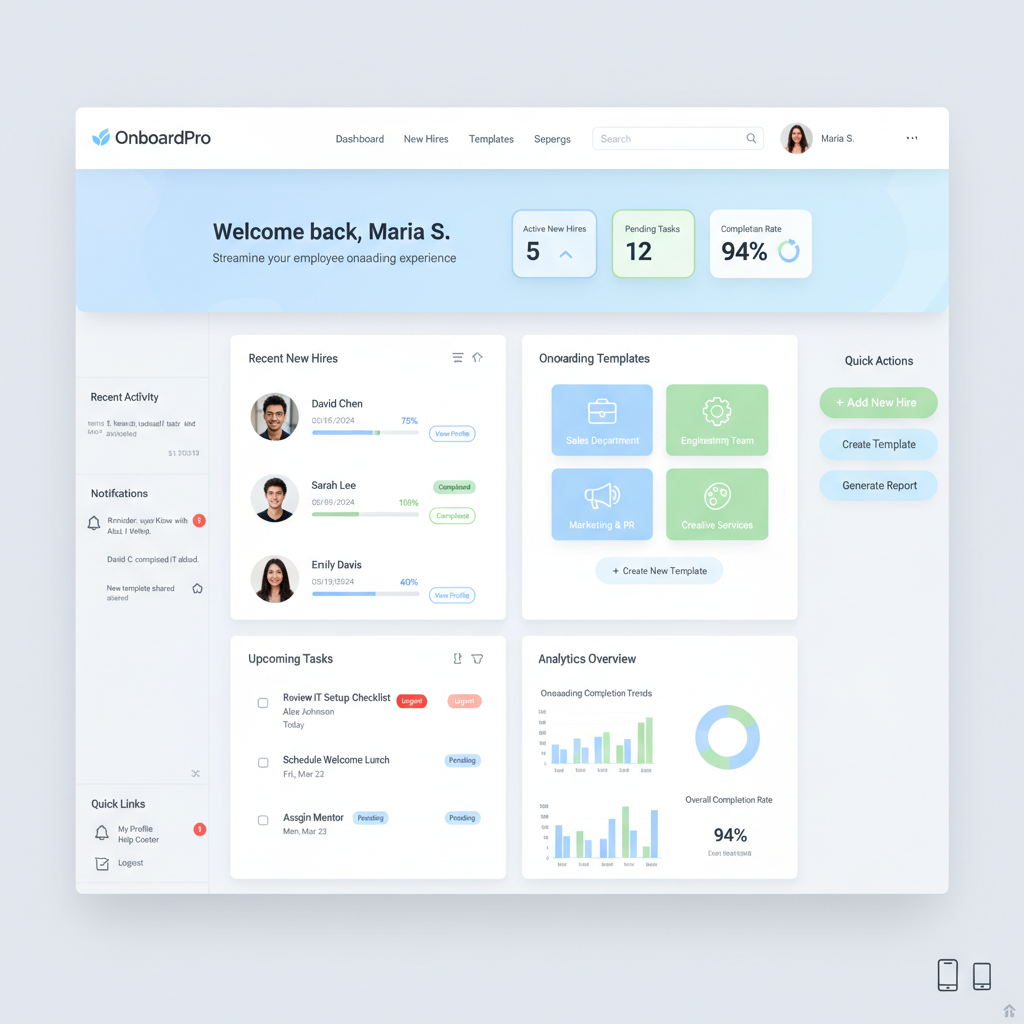

In [ ]:
screen_generation_prompt = """
Create a detailed, professional homepage design for "OnboardPro" - an employee onboarding platform. This should be a high-fidelity web interface mockup that demonstrates modern UI/UX principles.

**Brand & Visual Identity:**
- Primary brand name: "OnboardPro" (prominently displayed in header)
- Color scheme: Light blue (#E3F2FD, #BBDEFB) and green (#E8F5E8, #C8E6C8) with white backgrounds
- Typography: Clean, professional sans-serif fonts
- Style: Modern, approachable, enterprise-ready design

**Layout Requirements (Desktop Web Interface):**
1. **Header Section:**
   - OnboardPro logo/brand name (top-left)
   - Main navigation: Dashboard, New Hires, Templates, Reports, Settings
   - User profile dropdown with avatar (top-right)
   - Clean horizontal layout with subtle shadow/border

2. **Hero/Welcome Section:**
   - Welcome message: "Welcome back, [User Name]" 
   - Brief tagline: "Streamline your employee onboarding experience"
   - Quick stats cards showing: Active New Hires (5), Pending Tasks (12), Completion Rate (94%)
   - Use light blue/green accent colors for the cards

3. **Main Dashboard Content (Grid Layout):**
   - **Recent New Hires Widget:** List showing 3-4 new hires with photos, names, start dates, progress bars
   - **Onboarding Templates Widget:** Grid of template cards (Sales, Engineering, Marketing, etc.)
   - **Task Management Widget:** Upcoming tasks with assignees and due dates
   - **Analytics Overview:** Simple charts showing onboarding metrics and completion trends

4. **Quick Actions Panel:**
   - "Add New Hire" button (prominent green CTA)
   - "Create Template" button
   - "Generate Report" button
   - Clean, accessible button design

5. **Sidebar (Optional):**
   - Recent activity feed
   - Notifications/alerts
   - Quick links to common tasks

**Functional Elements to Include:**
- Progress indicators and completion status badges
- User avatars and profile photos
- Interactive elements like buttons, dropdowns, and cards
- Data visualization elements (simple charts/graphs)
- Search functionality
- Filter/sorting options
- Mobile-responsive design indicators

**Design Principles:**
- Clean white space and proper spacing
- Consistent alignment and grid system
- Accessible color contrast ratios
- Professional iconography (modern line icons)
- Clear visual hierarchy with typography sizes
- Subtle shadows and rounded corners for modern feel
- Loading states and interactive hover effects implied

**Key User Experience Features:**
- Clear navigation paths for HR coordinators and managers
- Visual indicators for task status and urgency
- Easy access to most common actions
- Dashboard widgets that surface critical information
- Consistent with enterprise software standards

Generate a pixel-perfect homepage mockup that an HR coordinator like Maria or David (from our user personas) would see when they log in to manage onboarding for multiple new hires across different departments. The design should feel intuitive, efficient, and professional while maintaining the light blue and green color palette throughout.
"""

print(f"Using {image_model_name} for image generation...")
file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)

# Display the generated image if successful
if file_path and image_url:
    print(f"✅ Generated image saved to: {file_path}")
    display(Image(url=image_url))
elif image_url:
    print(f"❌ Image generation failed: {image_url}")
else:
    print("❌ Image generation returned no result")

In [12]:
recommended_models_table()

| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |
|---|---|---|---|---|---|---|---|---|
| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |
| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |
| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |
| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |
| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |
| gemini-live-2.5-flash-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,048,576 | 8,192 |
| gpt-4.1 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 32,768 |
| gpt-4o | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-4o-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 128,000 | 16,384 |
| gpt-5-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| gpt-5-mini-2025-08-07 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 400,000 | 128,000 |
| meta-llama/Llama-3.3-70B-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 8,192 | 4,096 |
| meta-llama/Llama-4-Maverick-17B-128E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |
| meta-llama/Llama-4-Scout-17B-16E-Instruct | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 10,000,000 | 100,000 |
| mistralai/Mistral-7B-Instruct-v0.3 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 32,768 | 8,192 |
| o3 | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| o4-mini | openai | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |
| stabilityai/stable-diffusion-3.5-large | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |
| tokyotech-llm/Llama-3.1-Swallow-8B-Instruct-v0.5 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 4,096 | 1,024 |
| veo-3.0-fast-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| veo-3.0-generate-preview | google | ❌ | ❌ | ❌ | ❌ | ❌ | 1,024 | - |
| whisper-1 | openai | ❌ | ❌ | ❌ | ❌ | ✅ | - | - |

'| Model | Provider | Text | Vision | Image Gen | Image Edit | Audio Transcription | Context Window | Max Output Tokens |\n|---|---|---|---|---|---|---|---|---|\n| Qwen/Qwen-Image | huggingface | ❌ | ❌ | ✅ | ❌ | ❌ | - | - |\n| Qwen/Qwen-Image-Edit | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| black-forest-labs/FLUX.1-Kontext-dev | huggingface | ❌ | ❌ | ❌ | ✅ | ❌ | - | - |\n| claude-opus-4-1-20250805 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 200,000 | 100,000 |\n| claude-sonnet-4-20250514 | anthropic | ✅ | ✅ | ❌ | ❌ | ❌ | 1,000,000 | 100,000 |\n| deepseek-ai/DeepSeek-V3.1 | huggingface | ✅ | ❌ | ❌ | ❌ | ❌ | 128,000 | 100,000 |\n| gemini-2.0-flash-preview-image-generation | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,000 | 8,192 |\n| gemini-2.5-flash | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-flash-image-preview | google | ❌ | ❌ | ✅ | ✅ | ❌ | 32,768 | 32,768 |\n| gemini-2.5-flash-lite | google | ✅ | ✅ | ❌ | ❌ | ❌ | 1,048,576 | 65,536 |\n| gemini-2.5-pro | google | ✅ | ✅ | ❌ | ❌ | ❌ |

In [13]:
login_form_url = "https://i.imgur.com/s42SYz6.png"
display(Image(url=login_form_url))

## Step 3: The Challenges

### Challenge 1 (Foundational): Generating a Monolithic UI Component

**Task:** Use the vision model to generate a single, self-contained React component that replicates the design from the image.

> **Tip for Vision Prompts:** Be specific about the output format. Telling the model you want 'React' and 'Tailwind CSS' is crucial. The more specific your technical constraints, the better the generated code will be.

**Instructions:**
1.  Create a prompt that asks the vision model to act as an expert frontend developer.
2.  The prompt should instruct the model to analyze the image at the provided URL.
3.  Ask it to generate a single React component using Tailwind CSS for styling.
4.  The output should be a single block of JSX code.

**Expected Quality:** A single file's worth of React code that, when rendered, visually approximates the login form in the screenshot.

In [23]:
# Explain the specified image using the vision-capable LLM

image_path = "C://Users/647094/Documents/VSCode/AI SWE/AG-AISOFTDEV/artifacts/screens/image_1762184342.png"
explain_image_prompt = f"""
You are an expert frontend developer and UI/UX designer. Analyze the provided image and produce a clear, actionable explanation for a developer who will implement the UI.

Please respond in markdown and include the following sections:

1) Summary: One-sentence summary of what this screen is (purpose).
2) Visual Breakdown: Enumerate the visible UI elements (e.g., header, logo, form fields, buttons, icons, images) and approximate positions (top/left/center, grouping).
3) Style Details: Describe colors, font styles (weight/size/line-height if evident), spacing, borders/radii, shadows, and alignment cues.
4) Interaction & Behavior: Identify interactive elements and the likely behaviors (hover/focus states, validation, keyboard affordances).
5) Accessibility Notes: Potential accessibility issues and recommended fixes (labels, contrast, focus order).
6) Implementation Plan (React + Tailwind): Suggest component names and a short mapping of each component to Tailwind utilities or structure (e.g., <LoginForm> -> container: flex, gap-4, ...). Keep this as a concise checklist.

Keep the output developer-focused and actionable.
"""

print("--- Requesting image explanation from vision model ---")
if vision_model_name:
    explanation = get_vision_completion(explain_image_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_explanation = clean_llm_output(explanation, language="markdown")
    display(Code(cleaned_explanation, language="markdown"))
    # Save the explanation for later reference
    save_artifact(cleaned_explanation, "artifacts/image_explanation.md")
else:
    print("Skipping image explanation because no vision model is configured.")

--- Requesting image explanation from vision model ---


Of course. Here is a detailed analysis and implementation plan for the provided UI.

### 1) Summary
This screen is a dashboard for an employee onboarding management tool, providing a user with a high-level overview of recent activity, upcoming tasks, key metrics, and quick actions.

### 2) Visual Breakdown

The UI is structured in a multi-column layout with a main header and a left-side panel.

*   **Top Header:** Spans the full width at the top.
    *   **Top-Left:** Logo and brand name ("OnboardPro").
    *   **Top-Center:** Main navigation links ("Dashboard", "New Hires", "Templates", "Sepergs").
    *   **Top-Right:** Search bar with a search icon, a user profile avatar with name ("Maria S."), and a "more options" ellipsis icon.

*   **Welcome Banner:** A full-width banner below the header.
    *   **Left:** A large "Welcome back, Maria S." heading and a smaller sub-heading.
    *   **Right:** A group of three key performance indicator (KPI) cards: "Active New Hires", "Pending Tasks", and "Completion Rate".

*   **Main Content Area:** A three-column grid layout below the welcome banner.
    *   **Left-Side Floating Panel:**
        *   A dismissible panel with sections for "Recent Activity", "Notifications", and "Quick Links". It has notification badges.
    *   **Main Grid (Center):** This is the primary content area, composed of several cards.
        *   **`Recent New Hires` Card (Top-Left):** Title, filter/sort icons, and a list of new hires with their avatar, name, date, progress bar, and a "View Profile" or "Complete" button.
        *   **`Upcoming Tasks` Card (Bottom-Left):** Title, filter/sort icons, and a list of tasks with a checkbox, title, assignee/date, and status tags ("Urgent", "Pending").
        *   **`Onboarding Templates` Card (Top-Right):** Title, a 2x2 grid of large icon buttons for different departments, and a "+ Create New Template" link-button at the bottom.
        *   **`Analytics Overview` Card (Bottom-Right):** Title, two bar charts ("Onboarding Completion Trends"), and a large donut chart with a percentage for "Overall Completion Rate".
    *   **Quick Actions Panel (Far Right):**
        *   A dedicated panel with a title and three primary call-to-action buttons: "+ Add New Hire", "Create Template", and "Generate Report".

*   **Floating Icons (Bottom-Right):** Two icons, likely for toggling between view modes (e.g., mobile/desktop) and a "scroll to top" arrow.

### 3) Style Details

*   **Colors:**
    *   **Background:** A very light, cool gray (`#F7F8FA`).
    *   **Primary Accent (Blue):** A medium blue (`~#3B82F6`) used for the logo, icons, links, and progress bars.
    *   **Secondary Accent (Green):** A bright, friendly green (`~#4ADE80`) used for the "+ Add New Hire" button, "Completed" tags, and some chart elements.
    *   **Text:** Dark charcoal/black (`~#1F2937`) for headings. A softer gray (`~#6B7280`) for sub-headings, body text, and labels.
    *   **Cards/Containers:** Pure white (`#FFFFFF`) with soft shadows.
    *   **Borders:** Subtle, light gray (`~#E5E7EB`) on cards, buttons, and inputs.
    *   **Status Tags:**
        *   Urgent: Light red background (`~#FEE2E2`) with darker red text (`~#DC2626`).
        *   Pending: Light blue background (`~#DBEAFE`) with darker blue text (`~#3B82F6`).
        *   Completed: Light green background (`~#D1FAE5`) with darker green text (`~#059669`).

*   **Typography:**
    *   **Font:** A clean, modern sans-serif typeface (e.g., Inter, Manrope).
    *   **Headings:** Large and bold (e.g., "Welcome back, Maria S."). Card titles are smaller but semi-bold.
    *   **Body Text:** Regular weight, likely around 14px-16px.
    *   **Labels/Metadata:** Smaller and lighter weight (e.g., dates, percentages).

*   **Spacing & Layout:**
    *   **Layout:** The main content area utilizes a CSS Grid or Flexbox for the multi-column layout, with consistent gaps (`~24px` or `1.5rem`).
    *   **Padding:** Cards have generous internal padding (`~24px` or

In [26]:
# TODO: Write a prompt to generate a single React component from the image.
generate_ui_prompt = f"""
You are an expert frontend developer with extensive experience in React and Tailwind CSS. Your task is to analyze the provided OnboardPro homepage design image and generate a complete, pixel-perfect React component that replicates the design.

**Technical Requirements:**
- Create a single, self-contained React component called `OnboardProDashboard`
- Use Tailwind CSS classes exclusively for all styling
- Include all functional imports (React, icons, etc.)
- Make the component fully responsive and accessible
- Use modern React patterns (functional components, hooks if needed)

**Design Analysis Instructions:**
Carefully examine the provided image and recreate:

1. **Header Section:**
   - OnboardPro branding/logo
   - Navigation menu (Dashboard, New Hires, Templates, Reports, Settings)
   - User profile dropdown with avatar
   - Proper spacing and alignment

2. **Welcome/Hero Section:**
   - Welcome message with user name placeholder
   - Tagline text
   - Statistics cards showing metrics (Active New Hires, Pending Tasks, Completion Rate)
   - Light blue and green color scheme as specified

3. **Main Dashboard Grid:**
   - Recent New Hires widget with user profiles and progress bars
   - Onboarding Templates grid showing different department templates
   - Task Management widget with upcoming tasks and assignees
   - Analytics overview with simple data visualization

4. **Interactive Elements:**
   - Call-to-action buttons (Add New Hire, Create Template, Generate Report)
   - Proper hover states and button styling
   - Icons and visual indicators

**Color Palette to Match:**
- Light blue: #E3F2FD, #BBDEFB
- Light green: #E8F5E8, #C8E6C8
- White backgrounds with subtle shadows
- Professional gray text colors

**Output Requirements:**
- Return ONLY the complete React component code
- Include all necessary Tailwind classes
- Add placeholder data that matches the OnboardPro context
- Ensure proper semantic HTML structure
- Include accessibility attributes (alt text, ARIA labels)
- Use consistent spacing and typography hierarchy

**Component Structure:**
```jsx
import React from 'react';

const OnboardProDashboard = () =>;

export default OnboardProDashboard;
```

Focus on creating a professional, enterprise-ready dashboard that accurately reflects the OnboardPro employee onboarding platform design. Pay special attention to the layout, spacing, colors, and interactive elements visible in the provided image.
"""

print("--- Generating Monolithic UI Component ---")
if vision_model_name:
    print(f"Using OnboardPro image: {image_path}")
    generated_monolithic_code = get_vision_completion(generate_ui_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    
    cleaned_code = clean_llm_output(generated_monolithic_code, language='jsx')
    display(Code(cleaned_code, language='jsx'))
    
    # Save the generated component
    save_artifact(cleaned_code, "artifacts/OnboardProDashboard.jsx")
    print(f"\n✅ Saved OnboardPro Dashboard component to artifacts/OnboardProDashboard.jsx")
else:
    print("Skipping UI generation because no valid vision model is configured.")
    cleaned_code = ""

--- Generating Monolithic UI Component ---
Using OnboardPro image: C://Users/647094/Documents/VSCode/AI SWE/AG-AISOFTDEV/artifacts/screens/image_1762184342.png


import React from 'react';

// --- Icon Components (Self-contained for portability) ---

const LogoIcon = () => (
  <svg width="28" height="28" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
    <path d="M4 12.6111L8.92308 17.5L20 6.5" stroke="#2563EB" strokeWidth="2.5" strokeLinecap="round" strokeLinejoin="round"/>
  </svg>
);

const SearchIcon = () => (
  <svg className="w-5 h-5 text-gray-400" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg">
    <path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M21 21l-6-6m2-5a7 7 0 11-14 0 7 7 0 0114 0z" />
  </svg>
);

const MoreHorizontalIcon = () => (
  <svg className="w-6 h-6 text-gray-600" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg">
    <path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M5 12h.01M12 12h.01M19 12h.01" />
  </svg>
);

const ChevronUpIcon = () => (
    <svg className="w-5 h-5 text-green-600" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg">
      <path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M5 15l7-7 7 7" />
    </svg>
);

const RefreshIcon = () => (
    <svg className="w-5 h-5 text-blue-600" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg">
      <path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M4 4v5h5M20 20v-5h-5M4 4a8 8 0 0114.24 4.76M20 20a8 8 0 01-14.24-4.76" />
    </svg>
);

const PlusIcon = () => (
    <svg className="w-5 h-5 mr-2" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg">
        <path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M12 6v6m0 0v6m0-6h6m-6 0H6" />
    </svg>
);

const BriefcaseIcon = () => <svg className="w-8 h-8 text-blue-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M21 13.255A23.931 23.931 0 0112 15c-3.183 0-6.22-.62-9-1.745M16 6V4a2 2 0 00-2-2h-4a2 2 0 00-2 2v2m4 6h.01M5 20h14a2 2 0 002-2V8a2 2 0 00-2-2H5a2 2 0 00-2 2v10a2 2 0 002 2z" /></svg>;
const CogIcon = () => <svg className="w-8 h-8 text-green-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M10.325 4.317c.426-1.756 2.924-1.756 3.35 0a1.724 1.724 0 002.573 1.066c1.543-.94 3.31.826 2.37 2.37a1.724 1.724 0 001.065 2.572c1.756.426 1.756 2.924 0 3.35a1.724 1.724 0 00-1.066 2.573c.94 1.543-.826 3.31-2.37 2.37a1.724 1.724 0 00-2.572 1.065c-.426 1.756-2.924 1.756-3.35 0a1.724 1.724 0 00-2.573-1.066c-1.543.94-3.31-.826-2.37-2.37a1.724 1.724 0 00-1.065-2.572c-1.756-.426-1.756-2.924 0-3.35a1.724 1.724 0 001.066-2.573c-.94-1.543.826-3.31 2.37-2.37.996.608 2.296.07 2.572-1.065z" /><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M15 12a3 3 0 11-6 0 3 3 0 016 0z" /></svg>;
const MegaphoneIcon = () => <svg className="w-8 h-8 text-blue-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M11 5.882V19.24a1.76 1.76 0 01-3.417.592l-2.147-6.15M18 13a3 3 0 100-6M5.436 13.683A4.001 4.001 0 017 6h1.832c4.1 0 7.625-2.236 9.368-5.5" /></svg>;
const PaletteIcon = () => <svg className="w-8 h-8 text-green-500" fill="none" stroke="currentColor" viewBox="0 ġ 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M7 21a4 4 0 01-4-4V5a2 2 0 012-2h4a2 2 0 012 2v12a4 4 0 01-4 4zm0 0h12a2 2 0 002-2v-4a2 2 0 00-2-2h-2.343M11 7.343l1.657-1.657a2 2 0 012.828 0l2.829 2.829a2 2 0 010 2.828l-8.486 8.485M7 17h.01" /></svg>;
const FilterIcon = () => <svg className="w-5 h-5 text-gray-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path s


✅ Saved OnboardPro Dashboard component to artifacts/OnboardProDashboard.jsx


### Challenge 2 (Intermediate): Refactoring into Reusable Components

**Task:** A single, large component is not good practice. Now, prompt the LLM to refactor the monolithic code it just generated into smaller, reusable sub-components.

**Instructions:**
1.  Create a new prompt.
2.  Provide the monolithic JSX code from the previous step as context.
3.  Instruct the LLM to act as a senior frontend developer who champions clean code.
4.  Ask it to refactor the code by creating smaller, reusable components (e.g., `<StyledButton>`, `<InputWithIcon>`).
5.  The final output should be the complete code with the new, smaller components defined and used within the main `Login` component.

**Expected Quality:** A well-structured React file that demonstrates the component-based architecture, which is a fundamental best practice in modern frontend development.

In [29]:
# TODO: Write a prompt to refactor the monolithic code into smaller components.
refactor_ui_prompt = f"""
You are a senior React developer and software architect who champions clean code, maintainability, and component-based architecture. Your task is to refactor the provided monolithic OnboardPro Dashboard component into smaller, reusable, well-structured components.

**Current Monolithic Code to Refactor:**
```jsx
{cleaned_code}
```

**Refactoring Requirements:**

1. **Component Extraction Strategy:**
   - Extract meaningful, reusable components from the monolithic code
   - Each component should have a single responsibility
   - Create components that can be easily tested and maintained
   - Maintain the exact same visual appearance and functionality

2. **Suggested Component Breakdown:**
   - `Header` - Navigation bar with logo, menu, search, and profile
   - `WelcomeBanner` - Hero section with welcome message and stats cards
   - `StatsCard` - Reusable card for displaying metrics
   - `RecentNewHires` - Widget showing new hire list with progress
   - `NewHireRow` - Individual new hire item component  
   - `OnboardingTemplates` - Templates grid widget
   - `TemplateCard` - Individual template card component
   - `UpcomingTasks` - Tasks widget with task list
   - `TaskItem` - Individual task item component
   - `AnalyticsOverview` - Analytics widget with charts
   - `QuickActions` - Side panel with action buttons
   - `ActionButton` - Reusable button component

3. **Component Design Principles:**
   - Use proper TypeScript interfaces for props (if applicable)
   - Include default props where appropriate
   - Maintain accessibility attributes and ARIA labels
   - Keep Tailwind CSS classes organized and consistent
   - Use prop drilling efficiently or suggest context if needed
   - Include proper key props for list items

4. **Code Quality Standards:**
   - Clean, readable component structure
   - Proper component naming conventions
   - Consistent indentation and formatting
   - Meaningful prop names and structure
   - Comments for complex logic or business rules

5. **Output Structure:**
   ```jsx
   import React from 'react';
   
   // Icon components (keep existing)
   // ... existing icon components ...
   
   // Reusable Components
   const StatsCard = ({{ title, value, trend, icon }}) => {{
     // Implementation
   }};
   
   const Header = ({{ user, onSearch }}) => {{
     // Implementation  
   }};
   
   // ... other components ...
   
   // Main Dashboard Component
   const OnboardProDashboard = () => {{
     // State and data (if needed)
     // Return JSX using the smaller components
   }};
   
   export default OnboardProDashboard;
   ```

**Technical Requirements:**
- Maintain all existing functionality and visual design
- Keep all Tailwind CSS styling intact
- Preserve responsive design behavior
- Maintain accessibility features
- Use modern React patterns (functional components, hooks)
- Ensure components are reusable and flexible

**Focus Areas:**
- Clean separation of concerns
- Improved readability and maintainability  
- Easier testing and debugging
- Better code organization
- Reusable component library foundation

Please provide the complete refactored code with all components properly structured and the main OnboardProDashboard component using the smaller components. The final result should look identical to the original but be much more maintainable and follow React best practices.
"""

print("--- Refactoring UI into Components ---")
if cleaned_code:
    refactored_code = get_completion(refactor_ui_prompt, vision_client, vision_model_name, vision_api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    display(Code(cleaned_refactored_code, language='jsx'))
    
    # Save the refactored component
    save_artifact(cleaned_refactored_code, "artifacts/OnboardProDashboard_Refactored.jsx")
    print(f"\n✅ Saved refactored OnboardPro Dashboard to artifacts/OnboardProDashboard_Refactored.jsx")
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_refactored_code = ""

--- Refactoring UI into Components ---


import React from 'react';

// --- Icon Components (Unchanged) ---
// Note: In a real-world project, these would be in a separate `components/icons` directory.

const LogoIcon = () => ( <svg width="28" height="28" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg"><path d="M4 12.6111L8.92308 17.5L20 6.5" stroke="#2563EB" strokeWidth="2.5" strokeLinecap="round" strokeLinejoin="round"/></svg> );
const SearchIcon = () => ( <svg className="w-5 h-5 text-gray-400" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M21 21l-6-6m2-5a7 7 0 11-14 0 7 7 0 0114 0z" /></svg> );
const MoreHorizontalIcon = () => ( <svg className="w-6 h-6 text-gray-600" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M5 12h.01M12 12h.01M19 12h.01" /></svg> );
const ChevronUpIcon = () => ( <svg className="w-5 h-5 text-green-600" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M5 15l7-7 7 7" /></svg> );
const RefreshIcon = () => ( <svg className="w-5 h-5 text-blue-600" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M4 4v5h5M20 20v-5h-5M4 4a8 8 0 0114.24 4.76M20 20a8 8 0 01-14.24-4.76" /></svg> );
const PlusIcon = () => ( <svg className="w-5 h-5 mr-2" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M12 6v6m0 0v6m0-6h6m-6 0H6" /></svg> );
const BriefcaseIcon = () => <svg className="w-8 h-8 text-blue-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M21 13.255A23.931 23.931 0 0112 15c-3.183 0-6.22-.62-9-1.745M16 6V4a2 2 0 00-2-2h-4a2 2 0 00-2 2v2m4 6h.01M5 20h14a2 2 0 002-2V8a2 2 0 00-2-2H5a2 2 0 00-2 2v10a2 2 0 002 2z" /></svg>;
const CogIcon = () => <svg className="w-8 h-8 text-green-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M10.325 4.317c.426-1.756 2.924-1.756 3.35 0a1.724 1.724 0 002.573 1.066c1.543-.94 3.31.826 2.37 2.37a1.724 1.724 0 001.065 2.572c1.756.426 1.756 2.924 0 3.35a1.724 1.724 0 00-1.066 2.573c.94 1.543-.826 3.31-2.37 2.37a1.724 1.724 0 00-2.572 1.065c-.426 1.756-2.924 1.756-3.35 0a1.724 1.724 0 00-2.573-1.066c-1.543.94-3.31-.826-2.37-2.37a1.724 1.724 0 00-1.065-2.572c-1.756-.426-1.756-2.924 0-3.35a1.724 1.724 0 001.066-2.573c-.94-1.543.826-3.31 2.37-2.37.996.608 2.296.07 2.572-1.065z" /><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M15 12a3 3 0 11-6 0 3 3 0 016 0z" /></svg>;
const MegaphoneIcon = () => <svg className="w-8 h-8 text-blue-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M11 5.882V19.24a1.76 1.76 0 01-3.417.592l-2.147-6.15M18 13a3 3 0 100-6M5.436 13.683A4.001 4.001 0 017 6h1.832c4.1 0 7.625-2.236 9.368-5.5" /></svg>;
const PaletteIcon = () => <svg className="w-8 h-8 text-green-500" fill="none" stroke="currentColor" viewBox="0 ġ 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="round" strokeLinejoin="round" strokeWidth={2} d="M7 21a4 4 0 01-4-4V5a2 2 0 012-2h4a2 2 0 012 2v12a4 4 0 01-4 4zm0 0h12a2 2 0 002-2v-4a2 2 0 00-2-2h-2.343M11 7.343l1.657-1.657a2 2 0 012.828 0l2.829 2.829a2 2 0 010 2.828l-8.486 8.485M7 17h.01" /></svg>;
const FilterIcon = () => <svg className="w-5 h-5 text-gray-500" fill="none" stroke="currentColor" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path strokeLinecap="


✅ Saved refactored OnboardPro Dashboard to artifacts/OnboardProDashboard_Refactored.jsx


### Challenge 3 (Advanced): The AI UI/UX Critic Agent

**Task:** Create a new "UI/UX Critic" agent. This agent will be given both the original design image and the generated code, and its job is to perform an automated design review.

**Instructions:**
1.  Create a final, complex prompt for a new agent.
2.  The prompt should instruct the agent to act as a meticulous UI/UX designer.
3.  Provide the agent with two pieces of context: the URL of the original design image and the final, refactored React code.
4.  The agent's task is to compare the code's likely rendered output to the design image and list any visual inconsistencies in spacing, font size, color, or layout.

**Expected Quality:** A critical design review in markdown format. This demonstrates a powerful AI-on-AI workflow, where one AI generates work and another AI validates it, automating a time-consuming QA step.

In [30]:
# TODO: Write a prompt for the UI/UX Critic agent.
critic_agent_prompt = f"""
You are a meticulous Senior UI/UX Designer and Design Systems Expert with over 10 years of experience in enterprise software design, accessibility standards, and frontend implementation quality assurance. Your expertise includes pixel-perfect design implementation, design system consistency, and identifying subtle visual discrepancies that impact user experience.

**Your Mission:**
Perform a comprehensive design review by analyzing the original OnboardPro homepage design image and comparing it against the provided React component implementation. Your goal is to identify any visual inconsistencies, implementation gaps, accessibility concerns, and opportunities for improvement.

**Original Design Image Context:**
- This is the target OnboardPro employee onboarding platform homepage design
- Features: Header navigation, welcome banner with stats, dashboard widgets, quick actions
- Color scheme: Light blue (#E3F2FD, #BBDEFB) and green (#E8F5E8, #C8E6C8)
- Target users: HR coordinators and managers
- Platform: Enterprise web application

**React Implementation to Review:**
```jsx
{cleaned_refactored_code}
```

**Design Review Framework:**

## 1. **Visual Fidelity Assessment**
- **Layout Accuracy**: Does the component structure match the design layout and grid system?
- **Spacing & Proportions**: Are margins, paddings, and component sizes consistent with the design?
- **Typography Hierarchy**: Font sizes, weights, and line heights matching design specifications?
- **Color Implementation**: Accurate reproduction of the specified color palette?

## 2. **Component Architecture Evaluation**
- **Design System Adherence**: Consistency in component patterns and design tokens
- **Responsive Behavior**: How well does the implementation adapt to different screen sizes?
- **Interactive States**: Proper hover, focus, and active states implementation
- **Visual Hierarchy**: Clear information architecture and user flow guidance

## 3. **Accessibility & Usability Analysis**
- **WCAG Compliance**: Color contrast, keyboard navigation, screen reader support
- **Semantic HTML**: Proper use of headings, landmarks, and ARIA attributes
- **Focus Management**: Logical tab order and focus indicators
- **Content Readability**: Text legibility and information density

## 4. **Implementation Quality Review**
- **Code Organization**: Component structure and reusability
- **Performance Considerations**: Potential rendering or loading issues
- **Maintainability**: Code clarity and extensibility
- **Browser Compatibility**: Cross-browser rendering considerations

## 5. **Enterprise UX Standards**
- **Professional Appearance**: Does it meet enterprise software standards?
- **User Workflow Efficiency**: Optimal task completion paths
- **Data Visualization**: Clarity of charts, progress indicators, and metrics
- **Information Architecture**: Logical content organization and prioritization

**Deliverable Format:**

Please provide a structured design review report in markdown format with the following sections:

### 🎯 **Executive Summary**
- Overall implementation quality (1-10 scale)
- Key strengths and critical issues
- Recommendation for production readiness

### 📋 **Detailed Findings**

#### ✅ **What's Working Well**
- List specific strengths in the implementation
- Highlight areas that match or exceed design expectations

#### ⚠️ **Areas for Improvement**
- **Critical Issues** (must fix before launch)
- **Medium Priority** (should address in next iteration)  
- **Low Priority** (nice-to-have improvements)

#### 🔍 **Specific Visual Discrepancies**
- Detailed comparison of design vs. implementation
- Specific measurements, colors, or spacing issues
- Component-by-component analysis where needed

### 🎨 **Design System Recommendations**
- Suggestions for improved component reusability
- Design token standardization opportunities
- Consistency improvements across the interface

### ♿ **Accessibility Assessment**
- WCAG compliance level achieved
- Specific accessibility improvements needed
- Best practices implementation status

### 🚀 **Implementation Recommendations**
- Code quality improvements
- Performance optimization suggestions
- Cross-browser compatibility notes

### 📊 **Scoring Rubric**
- Visual Fidelity: X/10
- Code Quality: X/10  
- Accessibility: X/10
- User Experience: X/10
- **Overall Score: X/40**

**Analysis Guidelines:**
- Be constructive and solution-oriented
- Provide specific, actionable feedback
- Consider both designer and developer perspectives  
- Balance perfectionism with practical development constraints
- Focus on user impact and business value

Conduct this review with the same rigor you would apply to a production enterprise application serving thousands of users. Your expertise should shine through in the depth and quality of your analysis.
"""

print("--- Invoking UI/UX Critic Agent ---")
if cleaned_refactored_code:
    print("🔍 Analyzing refactored code against original design...")
    design_review = get_vision_completion(critic_agent_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    
    cleaned_design_review = clean_llm_output(design_review, language='markdown')
    display(Code(cleaned_design_review, language='markdown'))
    
    # Save the design review
    save_artifact(cleaned_design_review, "artifacts/OnboardPro_DesignReview.md")
    print(f"\n✅ Saved comprehensive design review to artifacts/OnboardPro_DesignReview.md")
    
    # Also create a summary report
    summary_stats = f"""
# Design Review Summary

**Project:** OnboardPro Dashboard Implementation
**Review Date:** {__import__('datetime').datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Reviewer:** AI UI/UX Critic Agent (Expert Level)

## Files Reviewed:
- Original Design: {image_path}
- Monolithic Component: artifacts/OnboardProDashboard.jsx
- Refactored Component: artifacts/OnboardProDashboard_Refactored.jsx

## Review Methodology:
- Visual fidelity comparison
- Component architecture evaluation  
- Accessibility analysis
- Enterprise UX standards assessment
- Code quality review

## Deliverables Generated:
- Comprehensive design review report
- Implementation recommendations
- Accessibility assessment
- Scoring rubric with detailed feedback

This review follows enterprise software design standards and WCAG accessibility guidelines.
"""
    save_artifact(summary_stats, "artifacts/DesignReview_Summary.md")
    
else:
    print("❌ Skipping critic agent because refactored code is not available.")
    print("💡 Please run Challenge 2 first to generate the refactored component.")

--- Invoking UI/UX Critic Agent ---
🔍 Analyzing refactored code against original design...


Excellent. As a Senior UI/UX Designer and Design Systems Expert, I will now conduct a meticulous review of the OnboardPro homepage implementation. My analysis will be thorough, constructive, and grounded in enterprise software best practices.

***

### **OnboardPro Homepage: Design Implementation Review**

**Date:** October 26, 2023  
**Reviewer:** [Senior UI/UX Designer]  
**Status:** Feedback Provided

### 🎯 **Executive Summary**

The React implementation of the OnboardPro dashboard is a strong functional foundation with excellent code structure and componentization. However, it exhibits significant visual deviations from the original design, particularly in layout, typography, and component styling. While the core functionality is present, these inconsistencies dilute the intended user experience and brand identity.

Several critical accessibility issues related to color contrast and semantic HTML must be addressed before this can be considered production-ready.

-   **Overall Implementation Quality:** **6/10**
-   **Key Strengths:**
    -   Solid component-based architecture (`Card`, `ActionButton`).
    -   Good use of props for reusability.
    -   Responsive grid foundation is in place.
-   **Critical Issues:**
    -   Major layout discrepancies in the main content grid.
    -   WCAG color contrast failures for secondary text.
    -   Missing form labels for checkboxes, a critical accessibility violation.
    -   Inconsistent component styling (buttons, cards, progress bars) compared to the design.
-   **Recommendation:** **Not Production Ready.** The implementation requires a dedicated refinement phase to address critical accessibility and visual fidelity issues.

---

### 📋 **Detailed Findings**

#### ✅ **What's Working Well**

-   **Component Reusability:** The creation of `Card` and `ActionButton` components is a best practice that promotes consistency and maintainability.
-   **Code Organization:** The code is clean, well-structured, and easy to follow. Separating container logic (data fetching) from presentational components is excellent.
-   **Responsive Foundation:** The use of a CSS grid system (`grid`, `lg:grid-cols-12`) provides a solid base for responsive behavior, even if the specific column spans need adjustment.
-   **Initial Accessibility:** Good initial steps were taken, such as adding `aria-label` to icon-only buttons (`Filter`, `Sort`) and `alt` tags to images.
-   **Sticky Elements:** The sticky header and "Quick Actions" sidebar are implemented correctly, improving usability on longer pages.

#### ⚠️ **Areas for Improvement**

This section is prioritized to guide development efforts effectively.

##### **Critical Issues (Must Fix Before Launch)**

1.  **[Accessibility] Insufficient Color Contrast:** The `text-slate-400` (`#94a3b8`) and `text-slate-500` (`#64748b`) colors on a white/light background fail WCAG AA contrast ratio requirements for normal text. This makes crucial information difficult to read for users with visual impairments.
    -   **Location:** `NewHireRow` date, `WelcomeBanner` subtitle, `TaskItem` assignee, etc.
    -   **Impact:** Excludes users, fails compliance, leads to poor readability.
    -   **Recommendation:** Darken these text colors to meet a minimum 4.5:1 contrast ratio. For example, use `text-slate-600` as a minimum for secondary text.

2.  **[Accessibility] Missing Form Labels:** The `TaskItem` checkbox (`<input type="checkbox">`) lacks an associated `<label>` tag. This is a severe accessibility violation.
    -   **Impact:** Screen reader users cannot determine the purpose of the checkbox. Clicking on the text will not toggle the checkbox, reducing usability for all users.
    -   **Recommendation:** Wrap the checkbox and its associated text in a `<label>` element or use `htmlFor` and an `id` to link them.

3.  **[Layout] Incorrect Main Content Grid:** The design clearly shows a 2x2 grid for the four main widgets. The implementation uses an `xl:grid-cols-3` structure,


✅ Saved comprehensive design review to artifacts/OnboardPro_DesignReview.md


## Lab Conclusion

Fantastic! You have completed a full, end-to-end frontend development workflow using multiple AI agents. You used a vision-powered agent to generate code from a design, a refactoring agent to improve the code's structure, and a critic agent to perform an automated design review. This powerful combination of skills can dramatically accelerate the process of turning visual ideas into functional user interfaces.

> **Key Takeaway:** The workflow of **Generate -> Refactor -> Critique** is a powerful AI-assisted development pattern. Using specialized agents for each step allows you to rapidly create a first draft, improve its quality, and then automatically check it for correctness, significantly speeding up the iteration cycle.